# Couple Candlesticks - Strategy - Backtesting 

### Import Library

In [17]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
from backtesting._plotting import set_bokeh_output
set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [18]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [19]:
data = dataset.copy()

In [20]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']
# data = data[data.index > '2024-01-01 00:00:00']

In [21]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2024-11-25 14:25:00,1298.0,1298.3,1296.7,1297.0,5524
2024-11-25 14:30:00,1297.1,1297.1,1297.1,1297.1,161
2024-11-25 14:45:00,1298.4,1298.4,1298.4,1298.4,5627


In [22]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] and r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] and r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond

def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] and r['Close'] == r['Low'] and r['Low'] < r['prev_low']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] and r['Close'] == r['High']  and r['High'] > r['prev_high']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond

def get_signal(r):
    signal = ''
    if r['condition_1'] == 'short' and r['condition_2'] == 'short':
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long':
        signal = 'long'
    return signal

In [23]:
def prepare_data(data):
    data['prev_low'] = data['Low'].shift(1)
    data['prev_high'] = data['High'].shift(1)
    data['max_5'] = data['High'].rolling(5).max()
    data['min_5'] = data['Low'].rolling(5).min()
    data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
    data['condition_1'] = data['condition_1'].shift(1)
    data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
    data['signal'] = data.apply(lambda r: get_signal(r), axis=1)
    return data

In [24]:
class CoupleCandlesticks(Strategy):
    max_sl = 3.5
    trailing_sl = 4.5
    tp_step = 20
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
                return
                
        if current_time.hour == 14 and current_time.minute >= 30:
            return

        close_price = self.data.Close[-1]
        if self.position.is_long:
            max_5 = self.data.max_5[-1]
            if close_price < max_5 - self.trailing_sl:
                self.position.close()
        elif self.position.is_short:
            min_5 = self.data.min_5[-1]
            if close_price > min_5 + self.trailing_sl:
                self.position.close()

        if self.position:
            return  
        signal = self.data.signal[-1]
        if signal == 'long':
            buy_price = close_price
            min_5 = self.data.min_5[-1]
            tmp_risk = buy_price - min_5
            risk = min(tmp_risk, self.max_sl)
            sl = buy_price - risk
            tp = buy_price + self.tp_step
            self.buy(size=1, sl=sl, tp=tp)
        elif signal == 'short':
            sell_price = close_price
            max_5 = self.data.max_5[-1]
            tmp_risk = max_5 - sell_price
            risk = min(tmp_risk, self.max_sl)
            sl = sell_price + risk
            tp = sell_price - self.tp_step
            self.sell(size=1, sl=sl, tp=tp)

In [25]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [26]:
# prepared_data[(prepared_data.index > '2024-11-06 00:00:00') & (prepared_data.index < '2024-11-06 15:00:00')]

In [27]:
bt = Backtest(prepared_data, CoupleCandlesticks, commission=.0003, exclusive_orders=True)
stats = bt.run()
# bt.plot()
print(stats)

Start                     2020-11-02 09:20:00
End                       2024-11-26 09:05:00
Duration                   1484 days 23:45:00
Exposure Time [%]                   33.373885
Equity Final [$]                   2155.18793
Equity Peak [$]                    2161.56649
Return [%]                          43.679195
Buy & Hold Return [%]               44.533511
Return (Ann.) [%]                    9.481564
Volatility (Ann.) [%]                6.951815
Sharpe Ratio                         1.363898
Sortino Ratio                        2.966827
Calmar Ratio                         1.923513
Max. Drawdown [%]                   -4.929294
Avg. Drawdown [%]                   -0.378299
Max. Drawdown Duration      370 days 01:15:00
Avg. Drawdown Duration        7 days 00:44:00
# Trades                                 1565
Win Rate [%]                        34.888179
Best Trade [%]                       2.295959
Worst Trade [%]                     -0.920813
Avg. Trade [%]                    

In [28]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,10,11,899.63003,901.4,-1.76997,-0.001967,2020-11-02 10:10:00,2020-11-02 10:15:00,None,0 days 00:05:00
1,1,45,46,906.97201,904.0,-2.97201,-0.003277,2020-11-02 14:30:00,2020-11-02 14:45:00,None,0 days 00:15:00
2,-1,52,65,907.92754,909.4,-1.47246,-0.001622,2020-11-03 09:25:00,2020-11-03 10:30:00,None,0 days 01:05:00
3,-1,106,111,907.02781,908.8,-1.77219,-0.001954,2020-11-04 09:40:00,2020-11-04 10:05:00,None,0 days 00:25:00
4,1,112,146,909.37273,912.5,3.12727,0.003439,2020-11-04 10:10:00,2020-11-04 14:25:00,None,0 days 04:15:00
...,...,...,...,...,...,...,...,...,...,...,...
1560,-1,51582,51592,1256.42296,1258.9,-2.47704,-0.001972,2024-11-20 09:10:00,2024-11-20 10:00:00,None,0 days 00:50:00
1561,1,51593,51625,1261.57836,1273.4,11.82164,0.009371,2024-11-20 10:05:00,2024-11-20 14:10:00,None,0 days 04:05:00
1562,1,51665,51680,1274.08211,1281.0,6.91789,0.005430,2024-11-21 13:15:00,2024-11-21 14:30:00,None,0 days 01:15:00
1563,1,51760,51767,1299.38970,1296.5,-2.88970,-0.002224,2024-11-25 11:15:00,2024-11-25 13:15:00,None,0 days 02:00:00


In [29]:
stats['_trades']['PnL'].sum()

655.1879300000522

In [30]:
trades = stats['_trades']

In [31]:
trades['cum_sum'] = trades['PnL'].cumsum()
X = np.array(range(0, len(trades['cum_sum'])))
Y = trades['cum_sum']

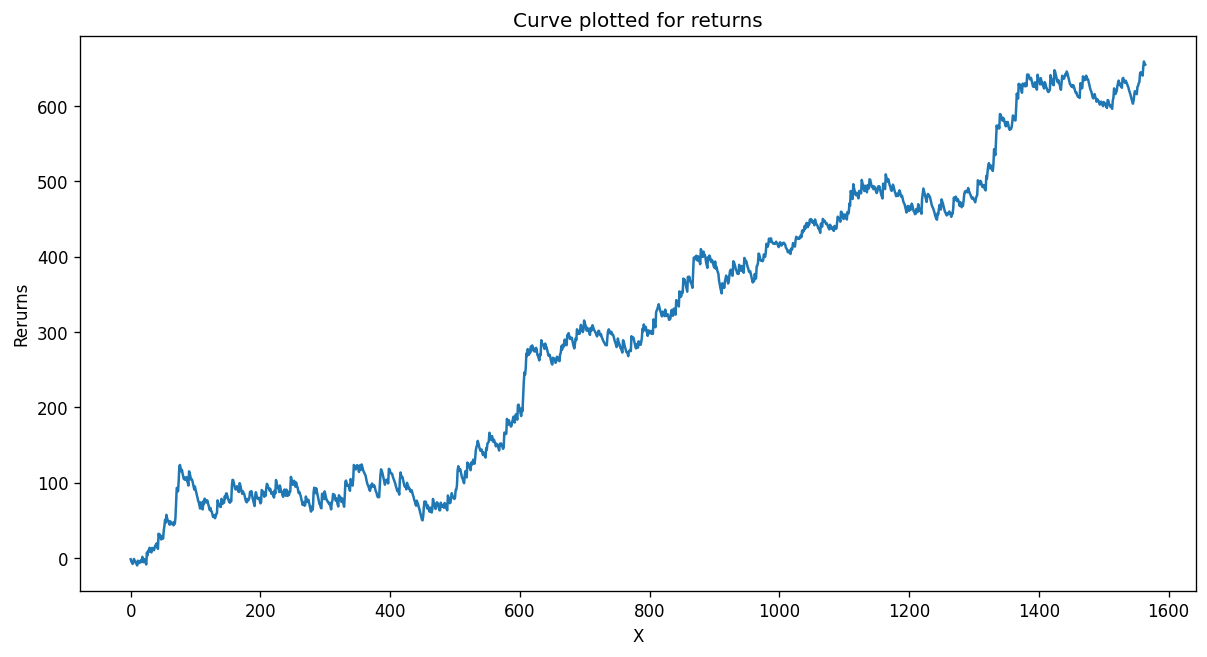

In [32]:
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

### Optimize

In [64]:
# trades = stats['_trades']
# max_d = trades['Duration'].max()
# trades[trades.Duration == max_d]

In [65]:
max_sl_params = [x / 10.0 for x in range(20, 60, 5)]
trailing_sl_params = [x / 10.0 for x in range(20, 60, 5)]
optimize_stats, heatmap = bt.optimize(max_sl=max_sl_params,
                                      trailing_sl=trailing_sl_params,
                                        maximize='Return [%]',
                                        random_state=0,
                                        return_heatmap=True)

In [66]:
optimize_stats

Start                     2024-01-02 09:20:00
End                       2024-11-12 14:45:00
Duration                    315 days 05:25:00
Exposure Time [%]                   40.739388
Equity Final [$]                  10165.35716
Equity Peak [$]                   10182.81363
Return [%]                           1.653572
Buy & Hold Return [%]               14.892124
Return (Ann.) [%]                    1.961706
Volatility (Ann.) [%]                1.058002
Sharpe Ratio                         1.854161
Sortino Ratio                        3.898898
Calmar Ratio                         4.181689
Max. Drawdown [%]                   -0.469118
Avg. Drawdown [%]                   -0.059711
Max. Drawdown Duration      159 days 02:35:00
Avg. Drawdown Duration        4 days 19:39:00
# Trades                                  282
Win Rate [%]                        36.524823
Best Trade [%]                       1.656413
Worst Trade [%]                     -0.514869
Avg. Trade [%]                    

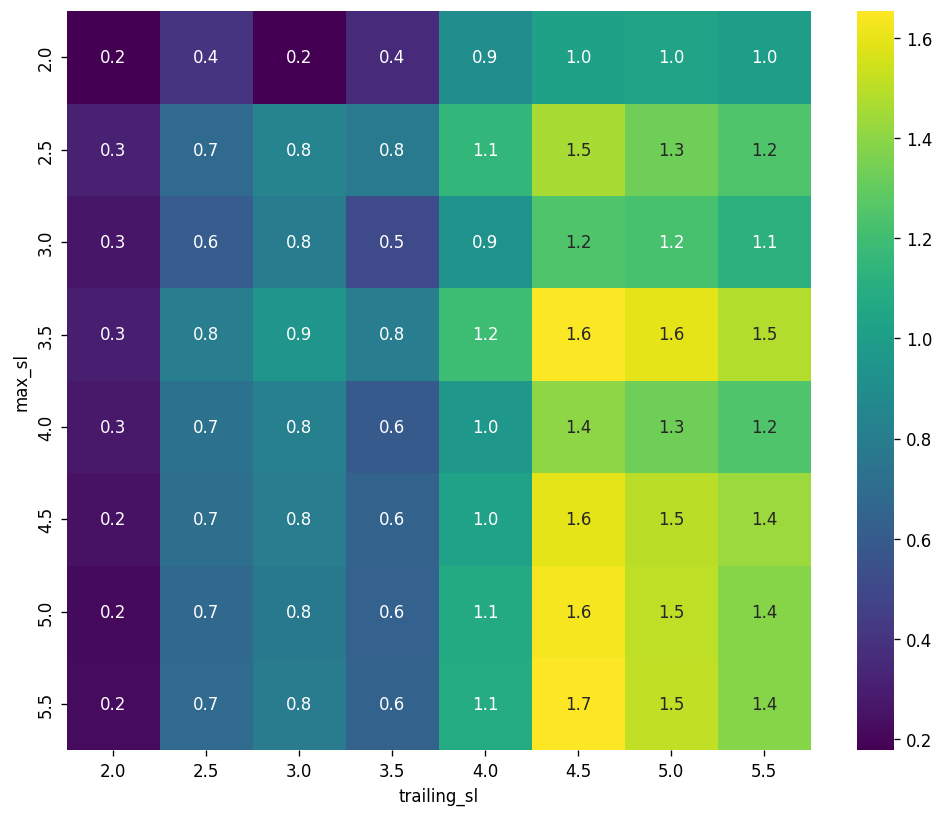

In [67]:
import seaborn as sns
# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.1f')
plt.show()

In [68]:
heatmap_df

trailing_sl,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5
max_sl,,,,,,,,
2.0,0.177218,0.397845,0.182156,0.354606,0.900962,1.022770,1.035541,0.993541
2.5,0.313252,0.681297,0.843432,0.779871,1.147987,1.458795,1.328566,1.246263
3.0,0.260806,0.608252,0.793543,0.507280,0.932452,1.248260,1.223841,1.120538
3.5,0.298431,0.798254,0.945241,0.796860,1.191032,1.644840,1.595421,1.485118
4.0,0.271431,0.725254,0.815119,0.588741,0.959913,1.400721,1.325302,1.244999
4.5,0.244431,0.710254,0.795119,0.639741,1.028704,1.595087,1.503460,1.431157
5.0,0.215431,0.668254,0.776119,0.631741,1.072704,1.635572,1.507945,1.384642
5.5,0.218431,0.679254,0.787119,0.637741,1.079704,1.653572,1.510945,1.383642


In [75]:
tp_params = [x / 10 for x in range(5, 210, 5)]
tp_optimize_stats, heatmap_tp = bt.optimize(tp_step=tp_params,
                                        maximize='Return [%]',
                                        random_state=0,
                                        return_heatmap=True)

In [76]:
tp_optimize_stats

Start                     2024-01-02 09:20:00
End                       2024-11-12 14:45:00
Duration                    315 days 05:25:00
Exposure Time [%]                   36.485623
Equity Final [$]                   10148.4795
Equity Peak [$]                   10169.03015
Return [%]                           1.484795
Buy & Hold Return [%]               14.892124
Return (Ann.) [%]                    1.763312
Volatility (Ann.) [%]                1.019072
Sharpe Ratio                         1.730313
Sortino Ratio                        3.790182
Calmar Ratio                          3.47632
Max. Drawdown [%]                   -0.507235
Avg. Drawdown [%]                   -0.056008
Max. Drawdown Duration      144 days 03:30:00
Avg. Drawdown Duration        5 days 06:59:00
# Trades                                  303
Win Rate [%]                        32.013201
Best Trade [%]                       1.698573
Worst Trade [%]                     -0.270864
Avg. Trade [%]                    

In [77]:
heatmap_tp

tp_step
0.5       -1.943860
1.0       -1.801625
1.5       -1.284844
2.0       -1.071818
2.5       -1.044571
3.0       -0.859736
3.5       -0.669694
4.0       -0.564876
4.5       -0.273103
5.0       -0.041324
5.5       -0.008337
6.0       -0.002127
6.5        0.025767
7.0        0.186468
7.5        0.441275
8.0        0.419427
8.5        0.513284
9.0        0.424323
9.5        0.496248
10.0       0.497208
10.5       0.479133
11.0       0.514133
11.5       0.582133
12.0       0.648133
12.5       0.778133
13.0       0.843133
13.5       0.763425
14.0       0.868425
14.5       0.943121
15.0       0.980121
15.5       1.065121
16.0       1.155121
16.5       1.182121
17.0       1.211121
17.5       1.258730
18.0       1.292730
18.5       1.278795
19.0       1.338795
19.5       1.398795
20.0       1.458795
20.5       1.484795
Name: Return [%], dtype: float64